In [2]:
# import re
import math
# import datetime
# from os import path
from PIL import Image

# Data Structures
import numpy as np
import pandas as pd

# Statistics and Processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Natural Language Processing
import nltk
from nltk.corpus import stopwords

# Visualization
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Dataset: Amazon Fine Food Reviews
# [URL] https://www.kaggle.com/snap/amazon-fine-food-reviews
reviewFull = pd.read_csv('data/Reviews.csv')
reviewSampled = reviewFull.sample(frac=.5)

In [3]:
# Rating function for a review. Biased towards reviews with more total views. 
#   E.g. 1 positive view out of 1 total view will not rate as high as 
#        1000 positive views out of 1200 total views.
#[CITE] https://www.evanmiller.org/how-not-to-sort-by-average-rating.html
def lbc(posVote, totalVote):
    #Total vote to reduce calculation
    negVote = totalVote - posVote
    #Return zero if no votes o
    if(totalVote == 0):
        return 0.0
    magic = ((posVote + 1.9208) / (totalVote) - 1.96 * math.sqrt((posVote * negVote) / (totalVote) + 0.9604) / 
                (totalVote)) / (1 + 3.8416 / (totalVote))
    return magic

In [4]:
reviewSampled = reviewSampled.drop('ProfileName', axis=1)

In [5]:
df = reviewSampled

# [CITE] https://codedump.io/share/w8TDdH1LYgGt/1/format-certain-floating-dataframe-columns-into-percentage-in-pandas
nullPercents = df.isnull().sum()/df.count()
nullPercents.sort_values(inplace=True,ascending=False)
nullPercents = pd.Series([str(round(val*100, 2))+"%" for val in nullPercents], index = nullPercents.index)
nullPercents

Summary                   0.01%
Text                       0.0%
Time                       0.0%
Score                      0.0%
HelpfulnessDenominator     0.0%
HelpfulnessNumerator       0.0%
UserId                     0.0%
ProductId                  0.0%
Id                         0.0%
dtype: object

In [6]:
#Remove 2 rows where numerator > denominator. Assume this is entry error in dataset
reviewFaultyRows = reviewSampled[reviewSampled['HelpfulnessNumerator'] > reviewSampled['HelpfulnessDenominator']]
reviewSampled = reviewSampled[reviewSampled['HelpfulnessNumerator'] <= reviewSampled['HelpfulnessDenominator']]

reviewFaultyRows.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


In [7]:
df = reviewSampled

# Create Lbc column associated with a review that contains the lbc value for that row
df['Lbc'] = df.apply(lambda row: lbc(row['HelpfulnessNumerator'], row['HelpfulnessDenominator']), axis=1)

# Create Timestamp column associated with a review
df['Timestamp'] = pd.to_datetime(df['Time'], unit='s')

df['ReviewLength'] = df['Text'].str.len()

reviewSampled = df

In [8]:
# Creates the bag of words array
# [CITE] https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words
vectorizer = CountVectorizer(lowercase = True, 
                             stop_words = 'english',
                             max_features = 1000)

bagOWord = vectorizer.fit_transform(df['Text'])
bagOWord = bagOWord.toarray()

In [9]:
# Add the bag of words array to the dataframe
reviewBagOWord = pd.DataFrame(bagOWord, columns=vectorizer.vocabulary_.keys(), dtype='int16')

In [10]:
# Accumulate the sum of each of the columns into 
sumOfWords = reviewBagOWord.sum(axis = 0)

In [11]:
# Creates the vector of Tf-Idf for each word in the review
# [CITE] https://stackoverflow.com/a/37593408
frequenizer = TfidfVectorizer(lowercase = True, 
                             stop_words = 'english',
                             max_features = 1000)

Tfidf = frequenizer.fit_transform(df['Text'])
Tfidf = Tfidf.toarray()

In [12]:
# Add the Tfidf to the dataframe
reviewTfidf = pd.DataFrame(Tfidf, columns=frequenizer.vocabulary_.keys(), dtype='float32')

In [13]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

#Make matplotlib pretty
matplotlib.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})

%config InlineBackend.figure_format = 'retina'

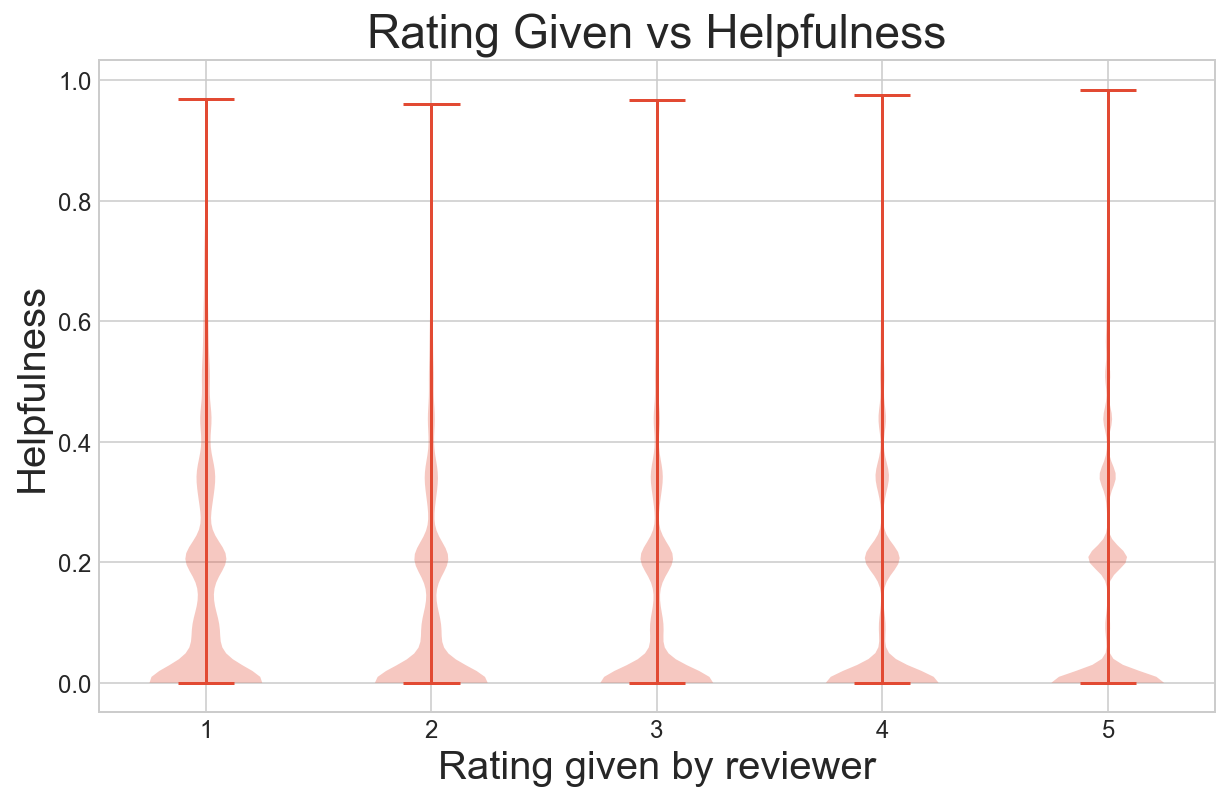

In [14]:
# Graph included entries with zero votes

df = reviewSampled

# [CITE] https://stackoverflow.com/a/43346806/3592716
sns.set_style('whitegrid')
fig, axes = plt.subplots()
axes.violinplot(dataset=[
    df[df.Score == 1]['Lbc'],
    df[df.Score == 2].Lbc,
    df[df.Score == 3].Lbc,
    df[df.Score == 4].Lbc,
    df[df.Score == 5].Lbc
])
axes.set_title('Rating Given vs Helpfulness')
axes.set_ylabel('Helpfulness')
axes.set_xlabel('Rating given by reviewer')
plt.show()

In [15]:
scoreGroupSkewed = reviewSampled[reviewSampled['HelpfulnessDenominator'] != 0]

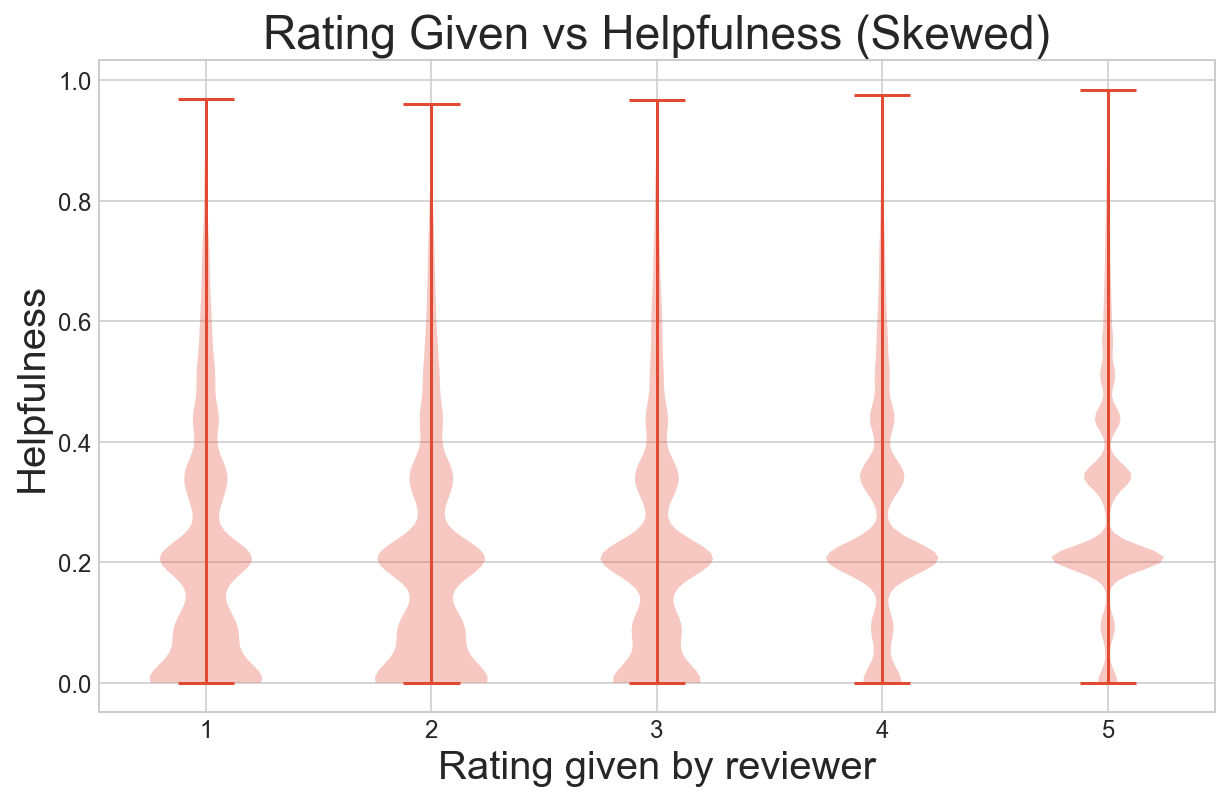

In [16]:
#As the rating the author goes up, the usefulness of the comment get better

# Graph containing only entries that have atleast 1 vote

df = scoreGroupSkewed

sns.set_style('whitegrid')
fig, axes = plt.subplots()
axes.violinplot(dataset=[
    df[df.Score == 1].Lbc,
    df[df.Score == 2].Lbc,
    df[df.Score == 3].Lbc,
    df[df.Score == 4].Lbc,
    df[df.Score == 5].Lbc
])
axes.set_title('Rating Given vs Helpfulness (Skewed)')
axes.set_ylabel('Helpfulness')
axes.set_xlabel('Rating given by reviewer')
plt.show()

In [17]:
sumOfWords = sumOfWords.sort_values(ascending=False)

sumOfWords20 = sumOfWords[0:20]
y_pos = np.arange(len(sumOfWords20))

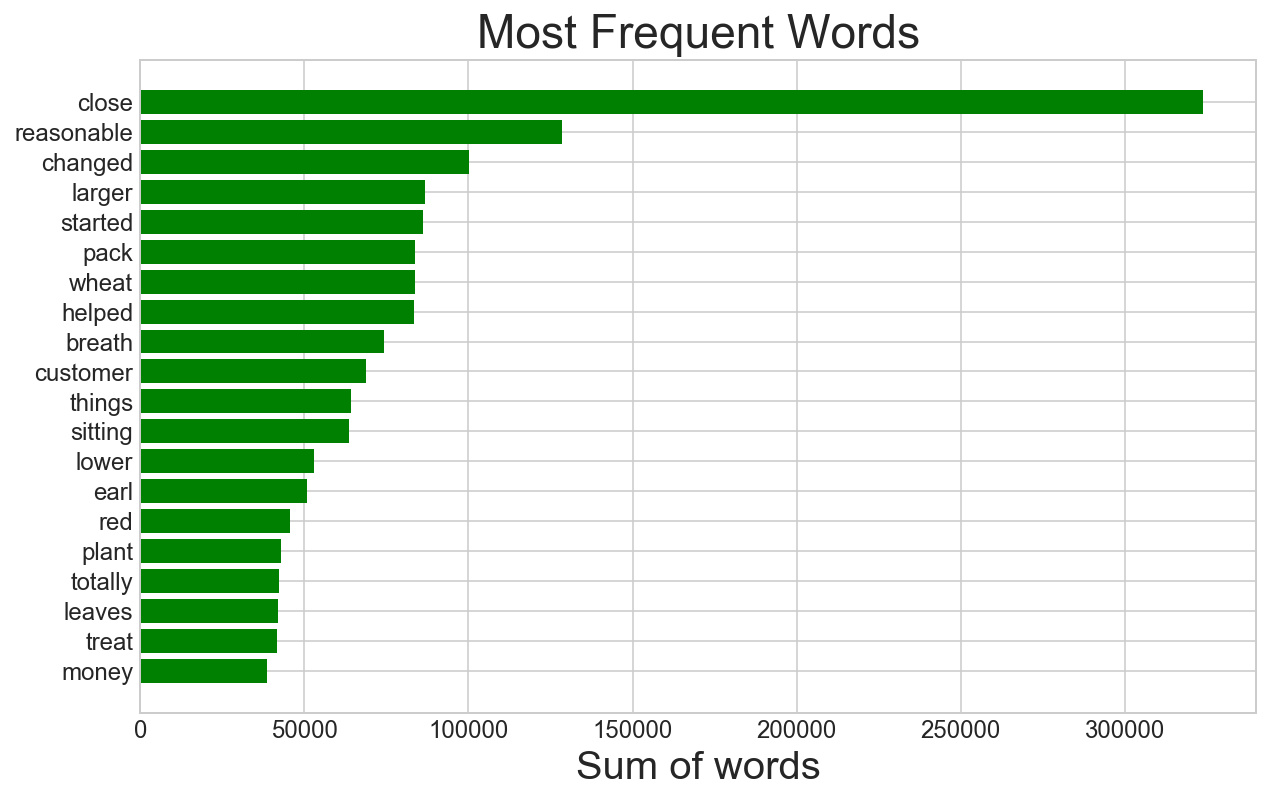

In [18]:
fig, ax = plt.subplots()

ax.barh(y_pos, sumOfWords20, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(sumOfWords20.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sum of words')

ax.set_title('Most Frequent Words')

plt.show()

In [19]:
# Accumulate the sum of each of the columns into 
tfidfMean = reviewTfidf.mean(axis = 0)
tfidfMean = tfidfMean.sort_values(ascending=False)

tfidfMean20 = tfidfMean[0:20]
y_pos = np.arange(len(tfidfMean20))

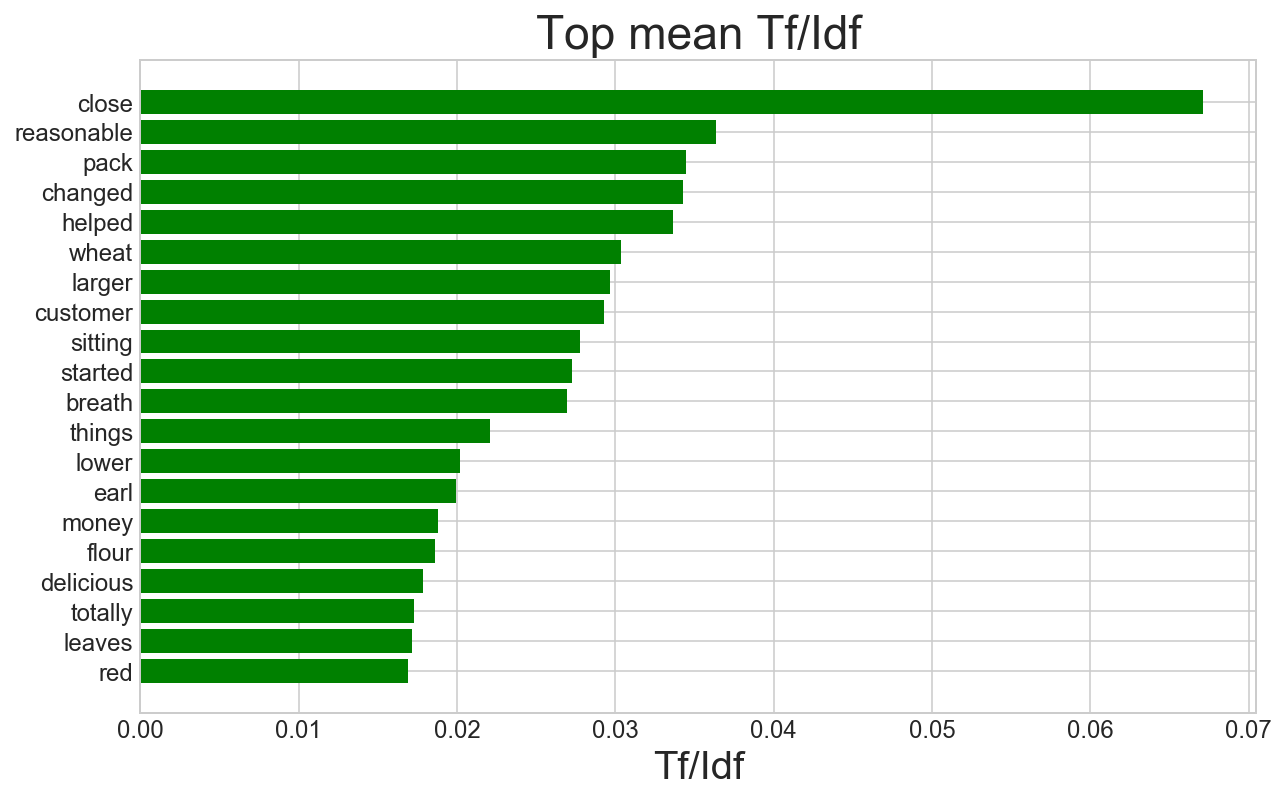

In [20]:
fig, ax = plt.subplots()

ax.barh(y_pos, tfidfMean20, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(tfidfMean20.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Tf/Idf')

ax.set_title('Top mean Tf/Idf')

plt.show()

In [21]:
tfidfMeanBot = tfidfMean.sort_values(ascending=True)

tfidfMeanBot20 = tfidfMeanBot[0:20]
y_pos = np.arange(len(tfidfMeanBot20))

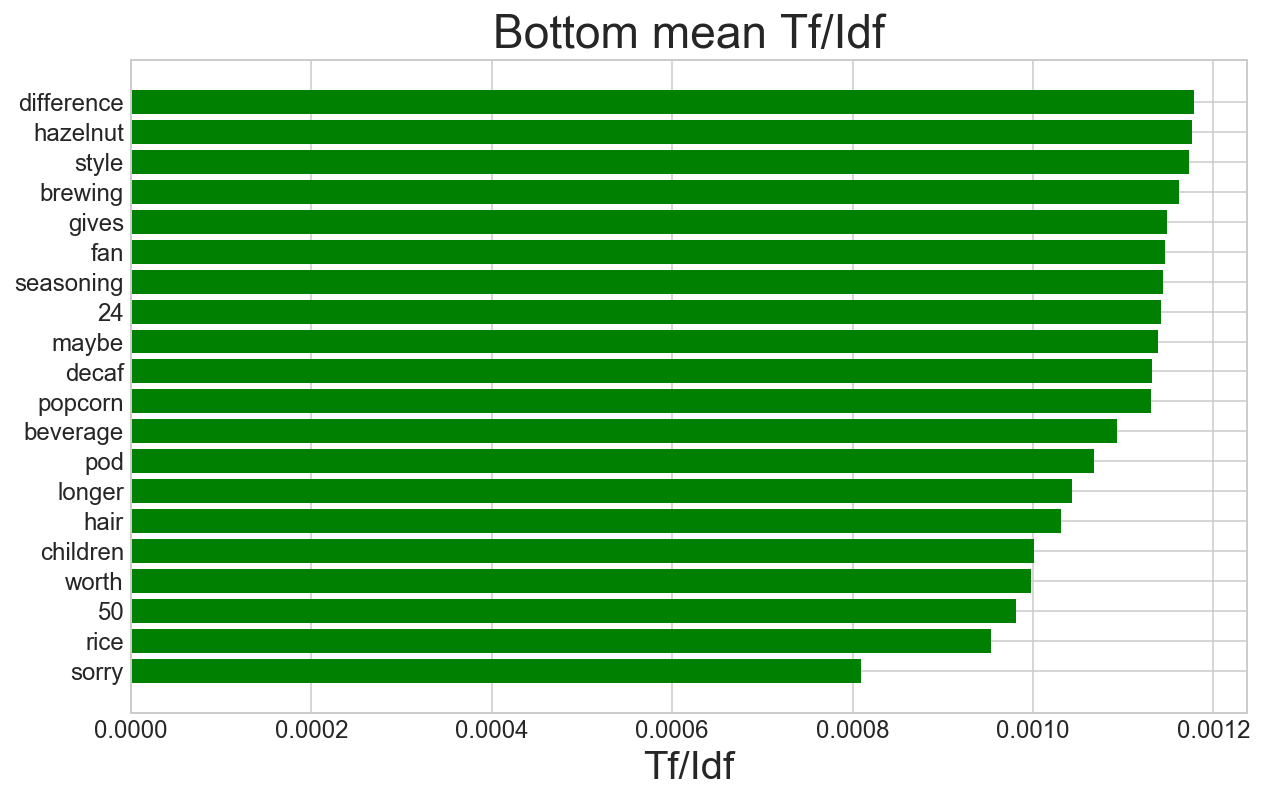

In [22]:
fig, ax = plt.subplots()

ax.barh(y_pos, tfidfMeanBot20, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(tfidfMeanBot20.index)
ax.set_xlabel('Tf/Idf')

ax.set_title('Bottom mean Tf/Idf')

plt.show()

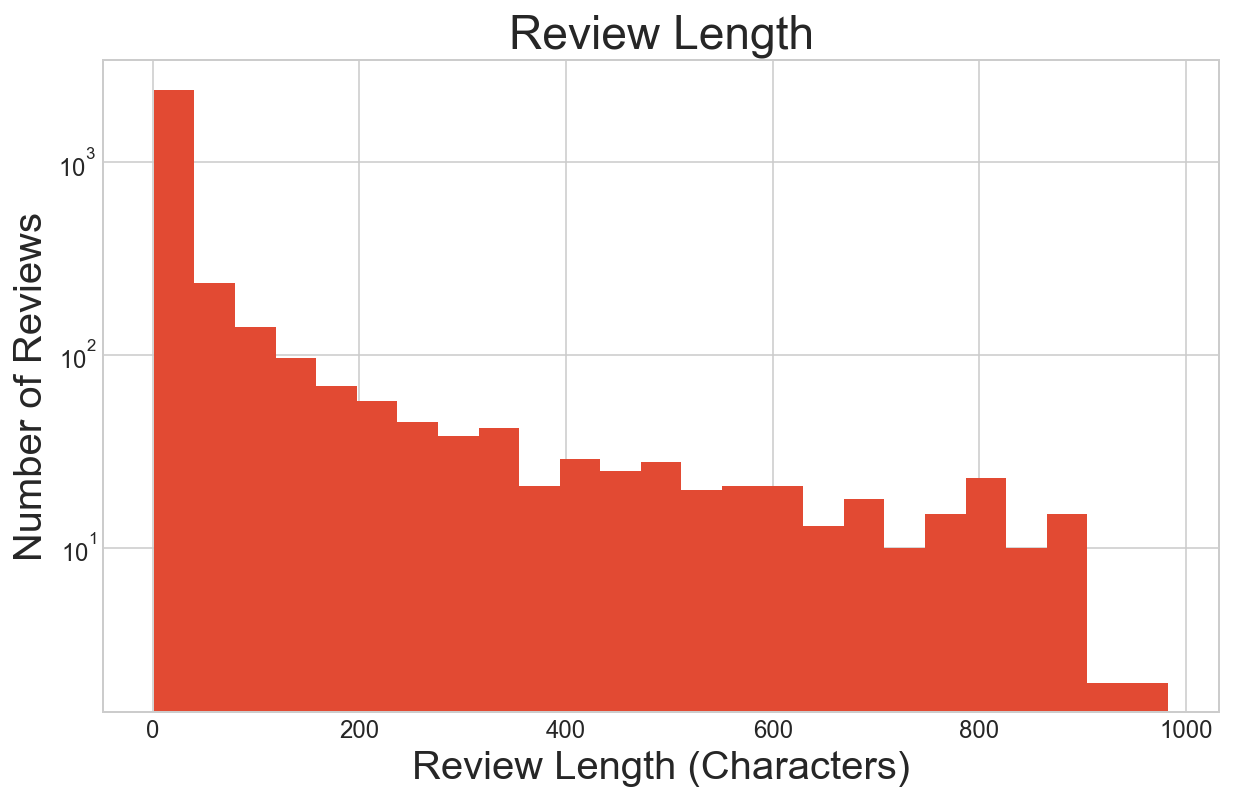

In [23]:
df = reviewSampled

plt.hist(df['ReviewLength'].value_counts(), bins=25)
plt.yscale('log')
plt.title("Review Length")
plt.ylabel('Number of Reviews')
plt.xlabel('Review Length (Characters)')
plt.show()

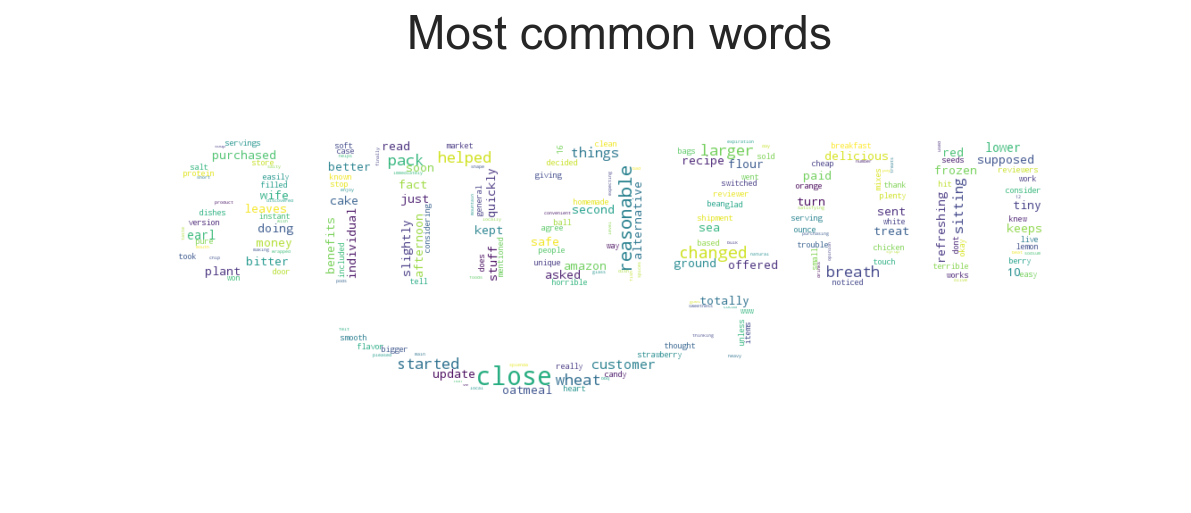

In [138]:
mw_mask = np.array(Image.open("img/amazon.jpg"))

wc = WordCloud(background_color='white', mask=mw_mask).generate_from_frequencies(sumOfWords)
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words')
plt.axis("off")
plt.show()

In [108]:
# Full dataset (reviews) grouped by star rating
reviewSampledScored = {1:reviewSampled[reviewSampled['Score'] == 1],
                       2:reviewSampled[reviewSampled['Score'] == 2],
                       3:reviewSampled[reviewSampled['Score'] == 3],
                       4:reviewSampled[reviewSampled['Score'] == 4],
                       5:reviewSampled[reviewSampled['Score'] == 5]}

In [111]:
# Columns are words, rows are reviews, cells are occurrence counts - grouped by star rating
reviewSumWordsScored = {1:pd.DataFrame(
                            vectorizer.fit_transform(reviewSampledScored[1]['Text']).toarray(),
                            columns=frequenizer.vocabulary_.keys(), dtype='int16'),
                        2:pd.DataFrame(
                            vectorizer.fit_transform(reviewSampledScored[2]['Text']).toarray(),
                            columns=frequenizer.vocabulary_.keys(), dtype='int16'),
                        3:pd.DataFrame(
                            vectorizer.fit_transform(reviewSampledScored[3]['Text']).toarray(),
                            columns=frequenizer.vocabulary_.keys(), dtype='int16'),
                        4:pd.DataFrame(
                            vectorizer.fit_transform(reviewSampledScored[4]['Text']).toarray(),
                            columns=frequenizer.vocabulary_.keys(), dtype='int16'),
                        5:pd.DataFrame(
                            vectorizer.fit_transform(reviewSampledScored[5]['Text']).toarray(),
                            columns=frequenizer.vocabulary_.keys(), dtype='int16')}

In [94]:
# Columns are words, rows are reviews, cells are word Tf-idf scores - grouped by star rating
reviewTfidfScored = {1:pd.DataFrame(
                            frequenizer.fit_transform(reviewSampledScored[1]['Text']).toarray(),
                            columns=frequenizer.vocabulary_.keys(), dtype='float32'),
                     2:pd.DataFrame(
                            frequenizer.fit_transform(reviewSampledScored[2]['Text']).toarray(),
                            columns=frequenizer.vocabulary_.keys(), dtype='float32'),
                     3:pd.DataFrame(
                            frequenizer.fit_transform(reviewSampledScored[3]['Text']).toarray(),
                            columns=frequenizer.vocabulary_.keys(), dtype='float32'),
                     4:pd.DataFrame(
                            frequenizer.fit_transform(reviewSampledScored[4]['Text']).toarray(),
                            columns=frequenizer.vocabulary_.keys(), dtype='float32'),
                     5:pd.DataFrame(
                            frequenizer.fit_transform(reviewSampledScored[5]['Text']).toarray(),
                            columns=frequenizer.vocabulary_.keys(), dtype='float32')}


In [95]:
reviewTfidfScoredMean = {1:reviewTfidfScored[1].mean(axis = 0).sort_values(ascending=False),
                         2:reviewTfidfScored[2].mean(axis = 0).sort_values(ascending=False),
                         3:reviewTfidfScored[3].mean(axis = 0).sort_values(ascending=False),
                         4:reviewTfidfScored[4].mean(axis = 0).sort_values(ascending=False),
                         5:reviewTfidfScored[5].mean(axis = 0).sort_values(ascending=False)}

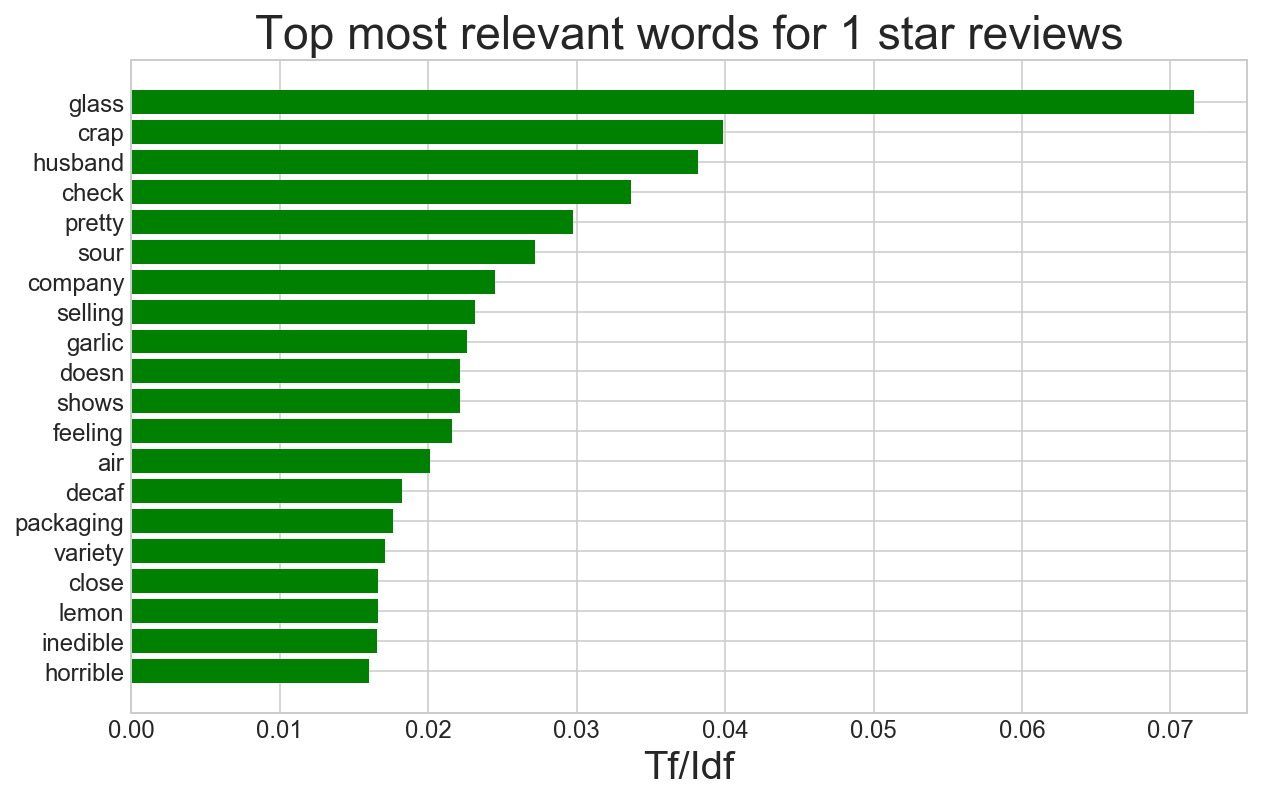

In [97]:
oneStar20RelevantWords = reviewTfidfScoredMean[1][0:20]
y_pos = np.arange(len(oneStar20RelevantWords))

fig, ax = plt.subplots()

ax.barh(y_pos, oneStar20RelevantWords, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(oneStar20RelevantWords.index)
ax.invert_yaxis()
ax.set_xlabel('Tf/Idf')

ax.set_title('Top most relevant words for 1 star reviews')

plt.show()

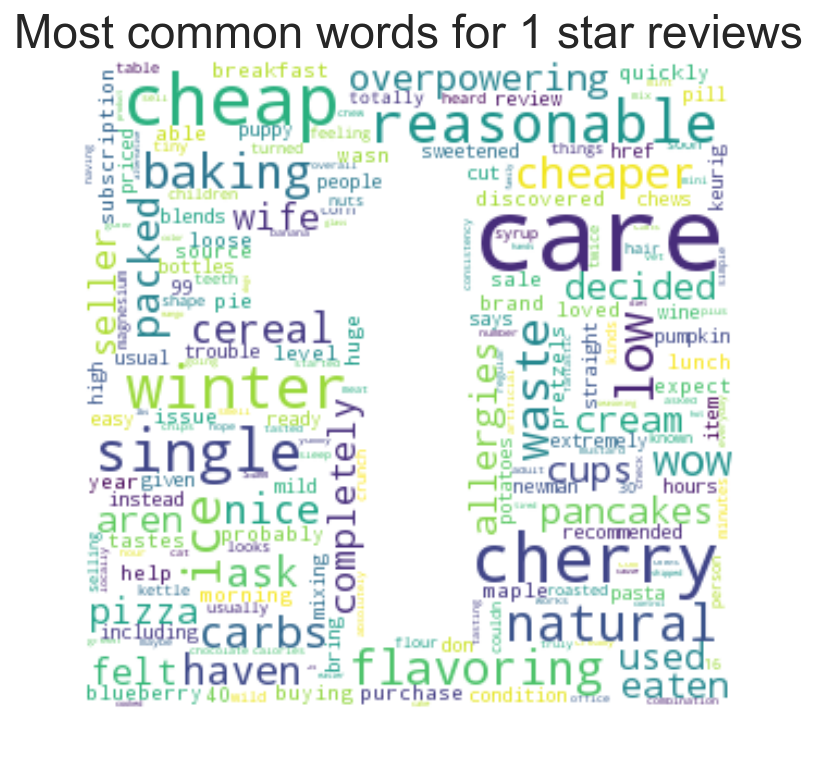

In [125]:
one_mask = np.array(Image.open("img/1.png"))

wc = WordCloud(background_color="white",
               mask=one_mask).generate_from_frequencies(reviewSumWordsScored[1].sum(axis = 0))
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words for 1 star reviews')
plt.axis("off")
plt.show()

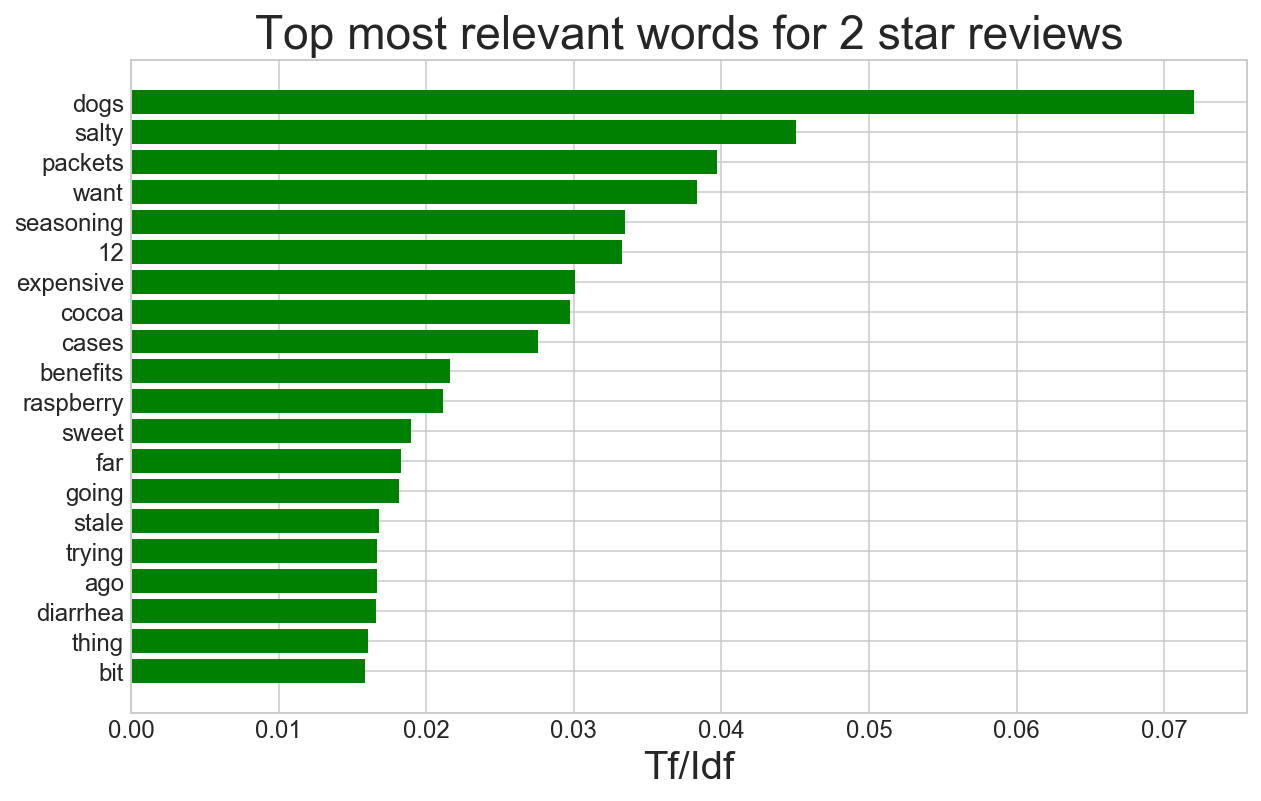

In [98]:
twoStar20RelevantWords = reviewTfidfScoredMean[2][0:20]
y_pos = np.arange(len(oneStar20RelevantWords))

fig, ax = plt.subplots()

ax.barh(y_pos, twoStar20RelevantWords, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(twoStar20RelevantWords.index)
ax.invert_yaxis()
ax.set_xlabel('Tf/Idf')

ax.set_title('Top most relevant words for 2 star reviews')

plt.show()

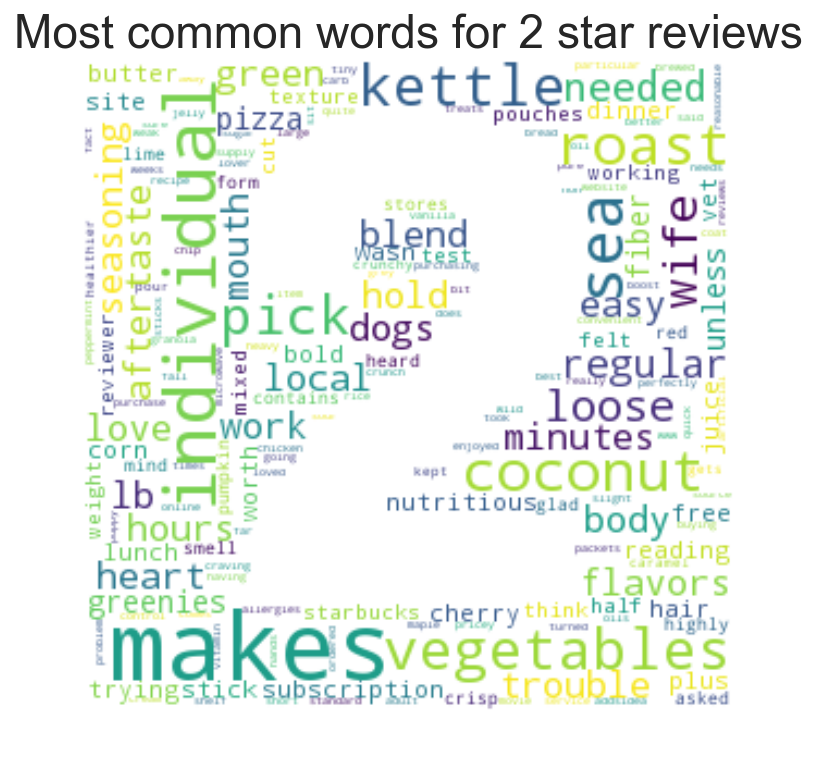

In [128]:
two_mask = np.array(Image.open("img/2.png"))

wc = WordCloud(background_color="white", 
               mask=two_mask).generate_from_frequencies(reviewSumWordsScored[2].sum(axis = 0))
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words for 2 star reviews')
plt.axis("off")
plt.show()

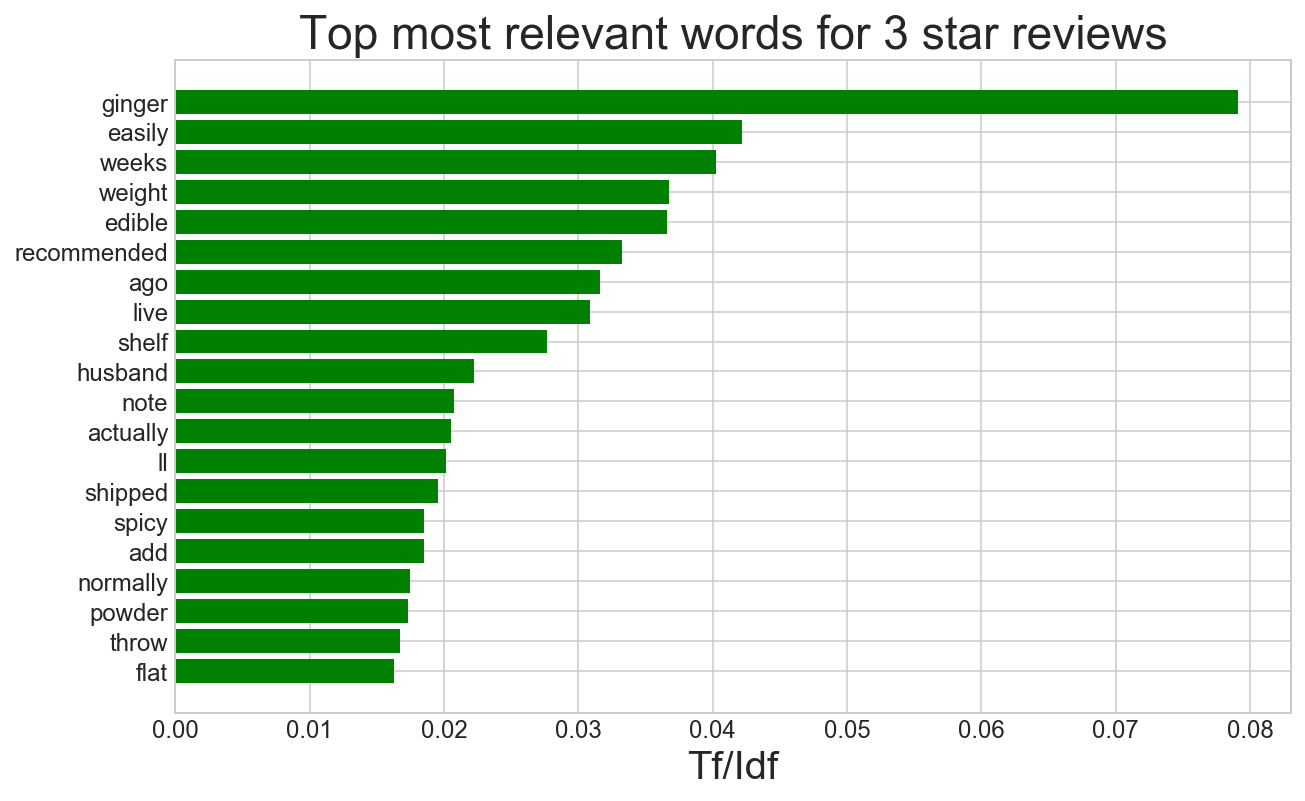

In [99]:
threeStar20RelevantWords = reviewTfidfScoredMean[3][0:20]
y_pos = np.arange(len(oneStar20RelevantWords))
wc = WordCloud().generate_from_frequencies(reviewSumWordsScored[1].sum(axis = 0))
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words for 1 star reviews')
plt.axis("off")
plt.show()
fig, ax = plt.subplots()

ax.barh(y_pos, threeStar20RelevantWords, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(threeStar20RelevantWords.index)
ax.invert_yaxis()
ax.set_xlabel('Tf/Idf')

ax.set_title('Top most relevant words for 3 star reviews')

plt.show()

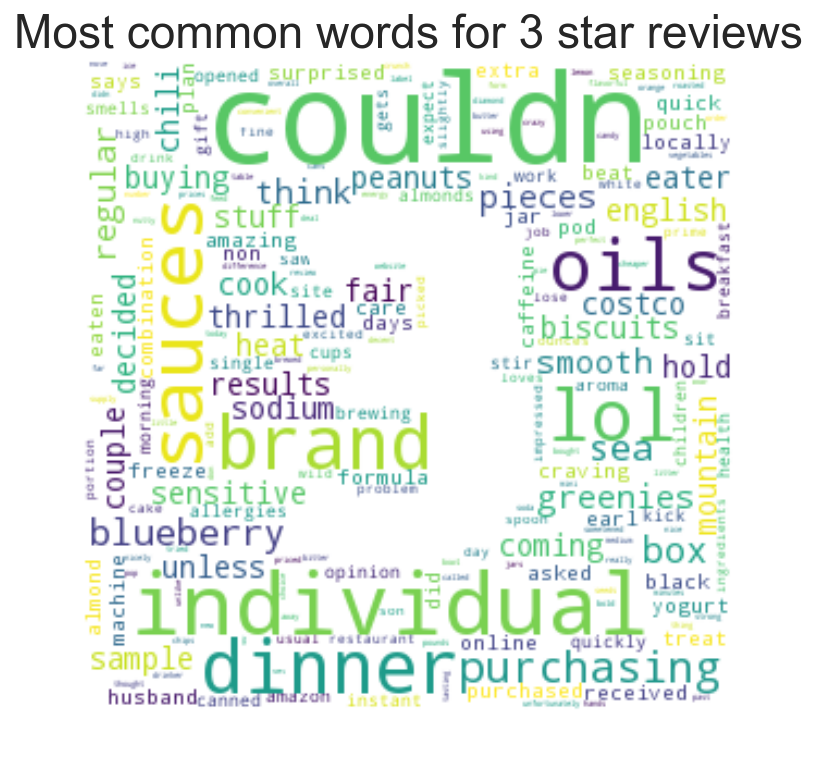

In [131]:
three_mask = np.array(Image.open("img/3.png"))

wc = WordCloud(background_color="white", 
               mask=three_mask).generate_from_frequencies(reviewSumWordsScored[3].sum(axis = 0))
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words for 3 star reviews')
plt.axis("off")
plt.show()

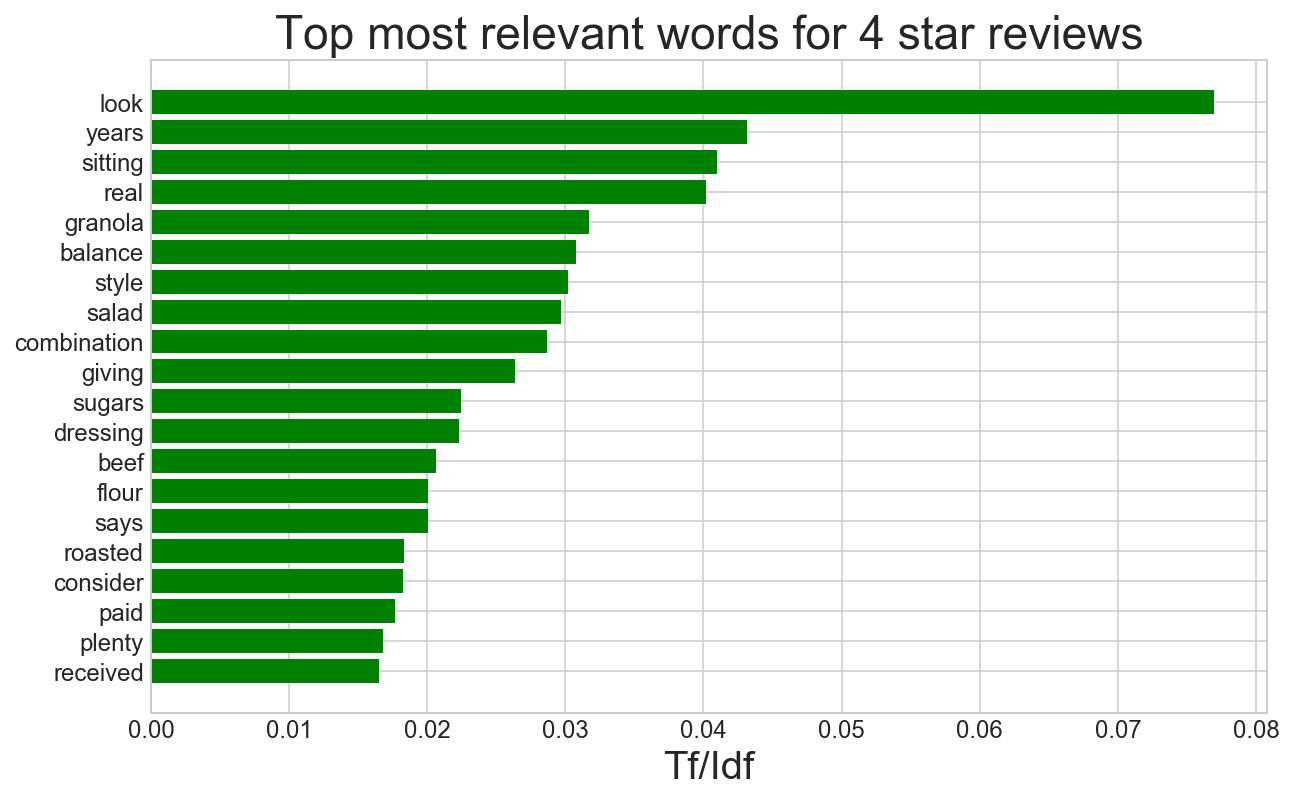

In [100]:
fourStar20RelevantWords = reviewTfidfScoredMean[4][0:20]
y_pos = np.arange(len(oneStar20RelevantWords))

fig, ax = plt.subplots()

ax.barh(y_pos, fourStar20RelevantWords, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(fourStar20RelevantWords.index)
ax.invert_yaxis()
ax.set_xlabel('Tf/Idf')

ax.set_title('Top most relevant words for 4 star reviews')

plt.show()

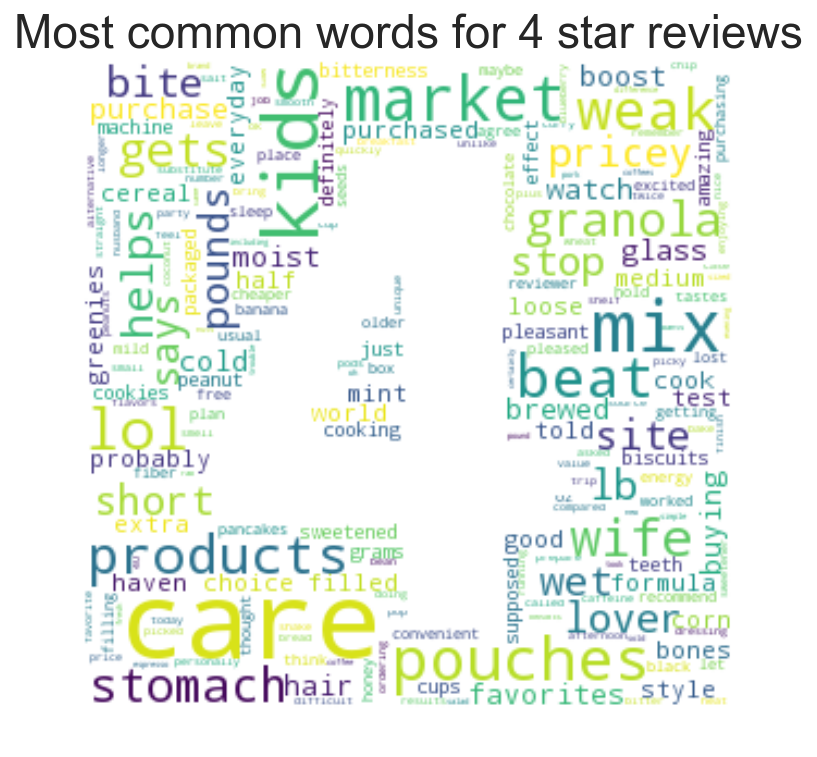

In [130]:
four_mask = np.array(Image.open("img/4.png"))

wc = WordCloud(background_color="white", 
               mask=four_mask).generate_from_frequencies(reviewSumWordsScored[4].sum(axis = 0))
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words for 4 star reviews')
plt.axis("off")
plt.show()

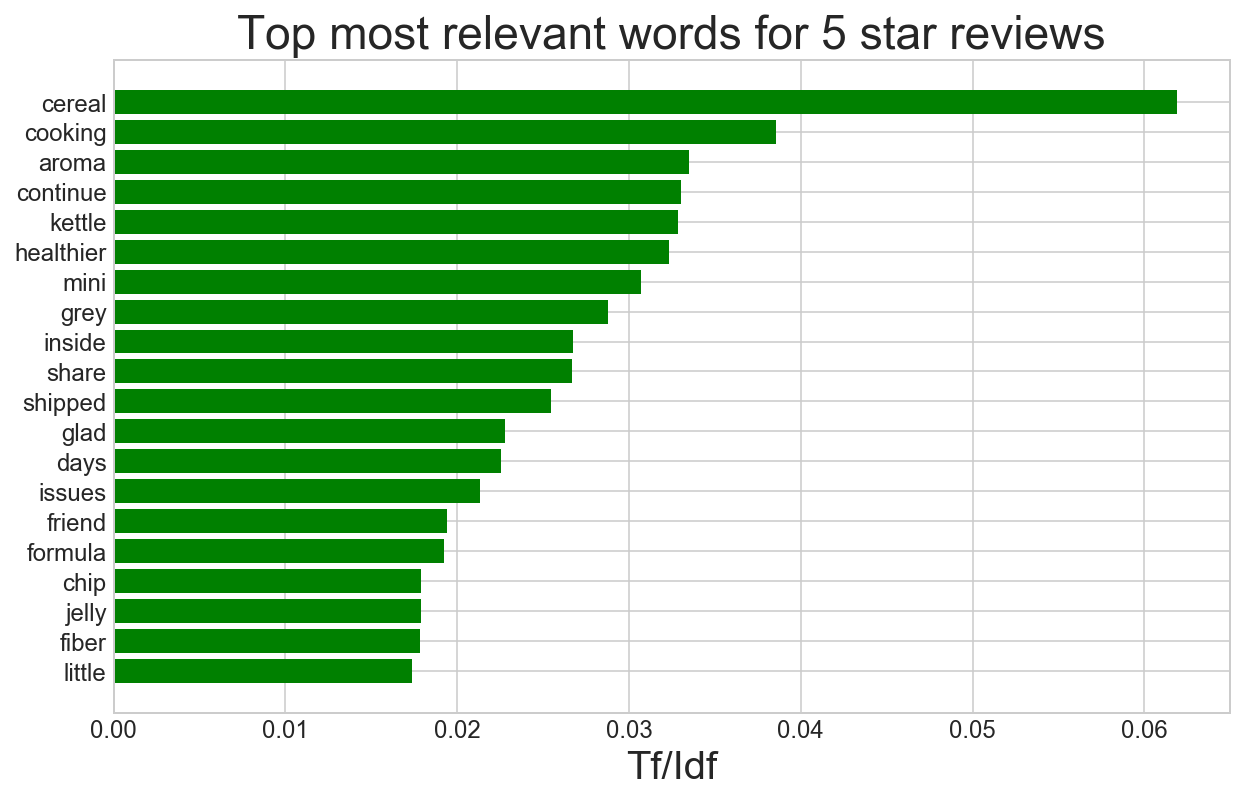

In [101]:
fiveStar20RelevantWords = reviewTfidfScoredMean[5][0:20]
y_pos = np.arange(len(oneStar20RelevantWords))

fig, ax = plt.subplots()

ax.barh(y_pos, fiveStar20RelevantWords, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(fiveStar20RelevantWords.index)
ax.invert_yaxis()
ax.set_xlabel('Tf/Idf')

ax.set_title('Top most relevant words for 5 star reviews')

plt.show()

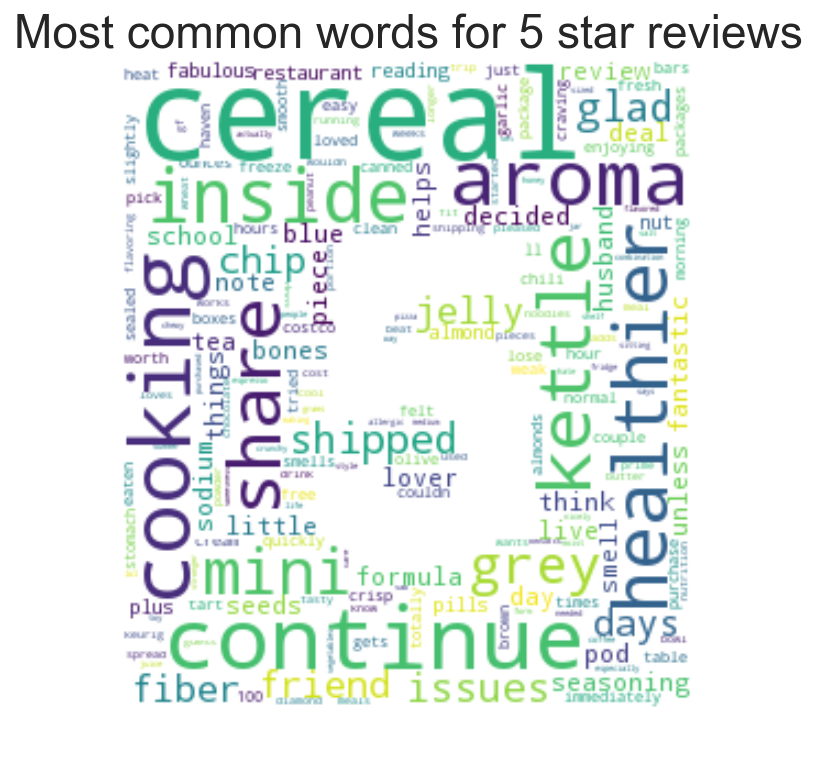

In [135]:
five_mask = np.array(Image.open("img/5.png"))

wc = WordCloud(background_color="white", 
               mask=five_mask).generate_from_frequencies(reviewSumWordsScored[5].sum(axis = 0))
plt.imshow(wc, interpolation='bilinear')
plt.title('Most common words for 5 star reviews')
plt.axis("off")
plt.show()

In [ ]:
#TODO (PAUL!!!)
# For each target class, visualize the most common relevant words and word frequencies. 
#  Are there any prevalent differences between your target classes? 
#  If you have many target classes, choose a representative subset of classes to perform this visualization. 